In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data availability

Tumour grade: 501 present  
IDH: 501 present  
1p/19q: 410 present / 91 missing

6 patients that were in the dataset twice were removed => Clinical_Data_cleaned.xlsx

Final dataset used: 495 patients


In [13]:
# Split data for 1 multiple classifier according to 2 dimensions

def prepare_data(df):
    # Extract the data from the relevant columns
    idh_status = df.iloc[:, 8]
    codeletion_status = df.iloc[:, 7]
    who_grade = df.iloc[:, 3]

    # Create binary classes for IDH mutation status
    binary_idh_status = idh_status.apply(lambda x: "Mutant" if x != "Wildtype" else "Wildtype")

    # Create a new column that combines two dimensions
    df['group_key'] = binary_idh_status + "_" + who_grade.astype(str)

    return df

def split_data(df):
    # Split the data into a training set (80%) and a temporary set (20%)
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['group_key'], random_state=42)

    # Split the temporary set evenly into validation and test sets (10% each)
    validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['group_key'], random_state=42)

    # Remove the added group_key column from training, validation, and test DataFrames
    train_df = train_df.drop(columns=['group_key'])
    validation_df = validation_df.drop(columns=['group_key'])
    test_df = test_df.drop(columns=['group_key'])

    print(f"Size of training set= {len(train_df)}")
    print(f"\nSize of validation set= {len(validation_df)}")
    print(f"\nSize of test set= {len(test_df)}")

    return train_df, validation_df, test_df

def main():
    file_path = "/Users/Gabriel/Desktop/MSc_Dissertation/Clinical_Data_cleaned.xlsx"

    # Read the Excel file, starting from row 1
    df = pd.read_excel(file_path, engine='openpyxl')

    # Export DataFrames to CSV files
    train_df.to_csv('train_data.csv', index=False)
    validation_df.to_csv('validation_data.csv', index=False)
    test_df.to_csv('test_data.csv', index=False)
    
    return train_df, validation_df, test_df

# Store datasets for visualization further down
train_df, validation_df, test_df = main()

size of training set= 323

size of validation set= 40

size of test set= 41


### Next, visualize the distribution (Age, IDH, 1p/19q codeletion, tumour grade) in the three sub-dataset

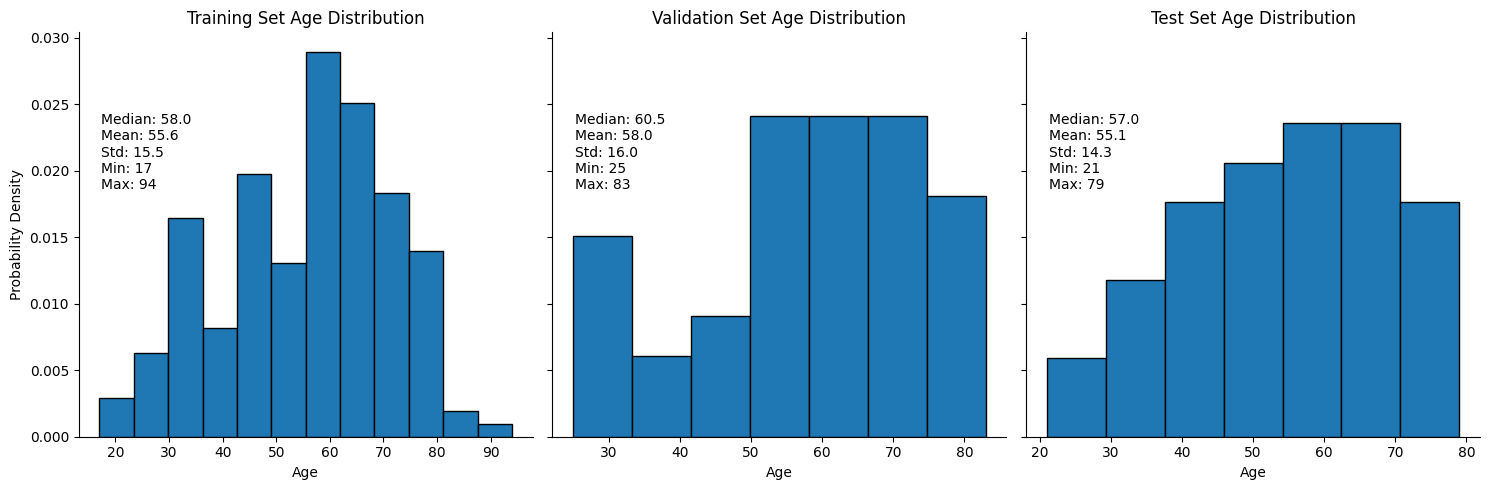

In [16]:
# Create a function to calculate and display summary statistics
def display_summary_statistics(ax, data, title):
    median = np.median(data)
    mean = np.mean(data)
    std = np.std(data)
    data_min = np.min(data)
    data_max = np.max(data)

    summary_text = f'Median: {median:.1f}\nMean: {mean:.1f}\nStd: {std:.1f}\nMin: {data_min}\nMax: {data_max}'
    ax.text(0.05, 0.8, summary_text, fontsize=10, ha='left', va='top', transform=ax.transAxes)

# Visualize age distribution

age_column_index = 2  # Replace with the correct column index for age data

# Extract age data for each set
train_age_data = train_df.iloc[:, age_column_index]
validation_age_data = validation_df.iloc[:, age_column_index]
test_age_data = test_df.iloc[:, age_column_index]

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)    
    
# Create histograms for each set
ax1.hist(train_age_data, bins='auto', edgecolor='black', density=True)
ax1.set_title('Training Set Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Probability Density')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
display_summary_statistics(ax1, train_age_data, 'Train Set Age Distribution')

ax2.hist(validation_age_data, bins='auto', edgecolor='black', density=True)
ax2.set_title('Validation Set Age Distribution')
ax2.set_xlabel('Age')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
display_summary_statistics(ax2, validation_age_data, 'Validation Set Age Distribution')

ax3.hist(test_age_data, bins='auto', edgecolor='black', density=True)
ax3.set_title('Test Set Age Distribution')
ax3.set_xlabel('Age')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
display_summary_statistics(ax3, test_age_data, 'Test Set Age Distribution')

# Adjust the layout and display the histograms
plt.tight_layout()
filename = os.path.expanduser('~/Desktop/AgeDistribution.png')            
plt.savefig(filename, dpi=300)
plt.show()


### Next, visualize distribution of relevant attributes accros subsets

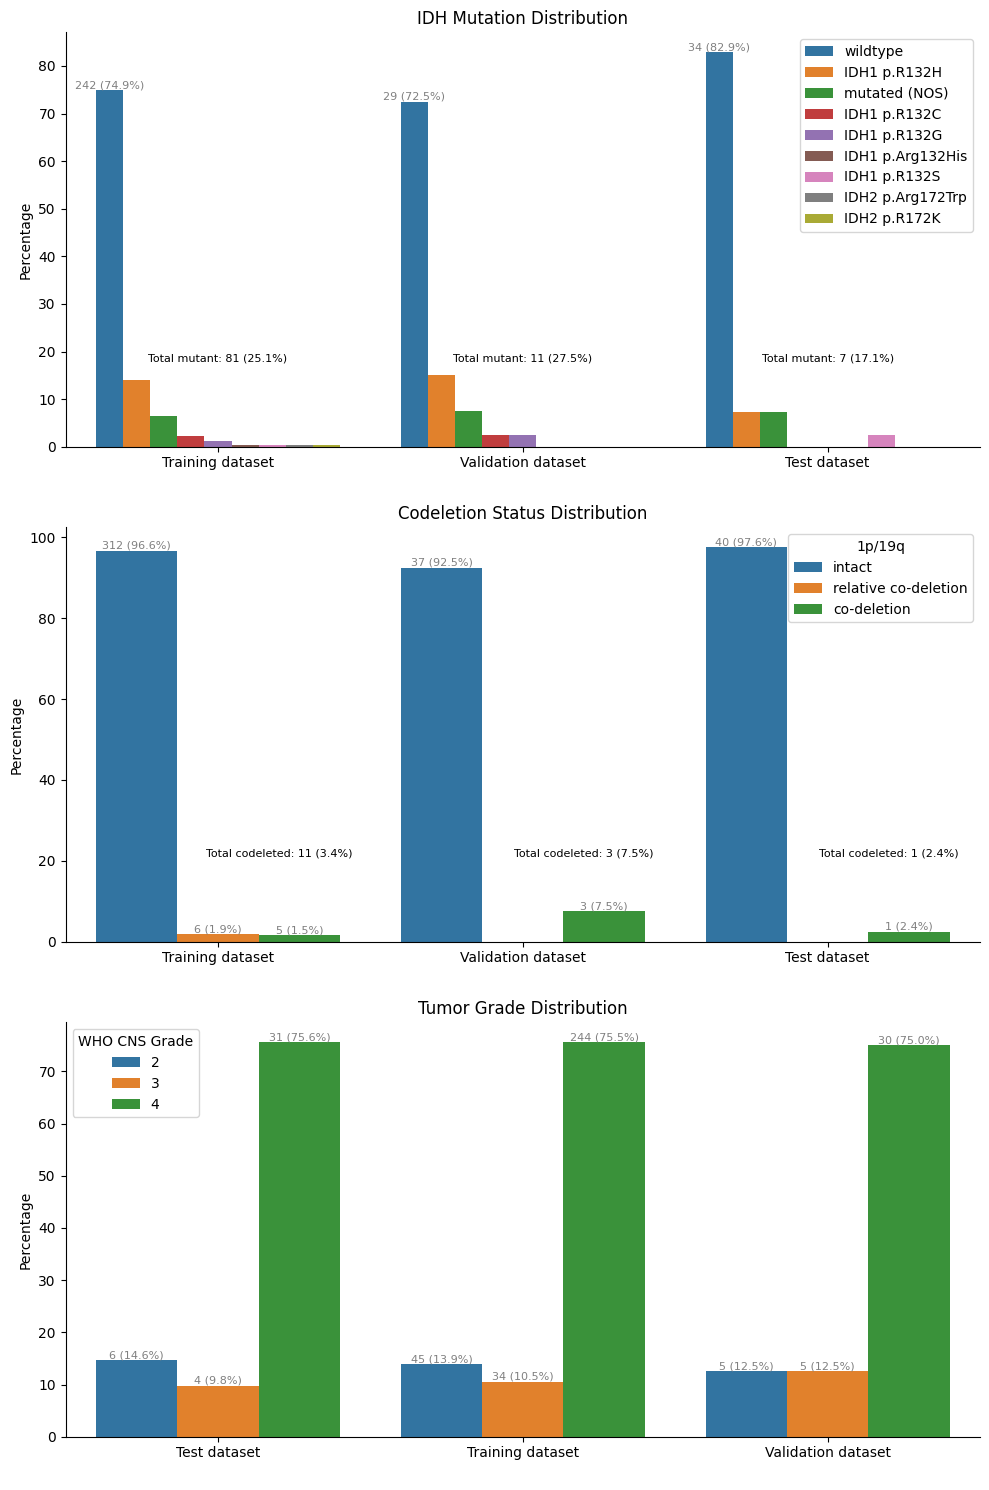

In [15]:
# Normalize countplots by calculating the percentages
def normalize_countplot(df, group_col, hue_col):
    #df[hue_col] = df[hue_col].astype(str).str.lower()
    counts = df.groupby([group_col, hue_col]).size().reset_index(name='counts')
    total_counts = df.groupby(group_col).size().reset_index(name='total_counts')
    counts = counts.merge(total_counts, on=group_col)
    counts['percentage'] = counts['counts'] / counts['total_counts'] * 100
    return counts

def sort_within_groups(df, group_col, sort_col):
    # Convert the dataset column to a categorical data type with the desired order of categories
    cat_dtype = pd.CategoricalDtype(['Training dataset', 'Validation dataset', 'Test dataset'], ordered=True)
    df['dataset'] = df['dataset'].astype(cat_dtype).cat.reorder_categories(['Training dataset', 'Validation dataset', 'Test dataset'])
    # Sort the DataFrame within each group by the specified column(s)
    return df.groupby(group_col, group_keys=False).apply(lambda g: g.sort_values([sort_col, 'dataset'], ascending=[False, True]))

# Add a new column to each DataFrame indicating the dataset it belongs to
train_df['dataset'] = 'Training dataset'
validation_df['dataset'] = 'Validation dataset'
test_df['dataset'] = 'Test dataset'

# Combine the DataFrames into one
combined_df = pd.concat([train_df, validation_df, test_df])

# Standardize capitalization for the '1p/19q' column
combined_df['1p/19q'] = combined_df['1p/19q'].replace({'Co-deletion': 'co-deletion'})

normalized_counts = normalize_countplot(combined_df, 'dataset', 'IDH')
normalized_codeletion_counts = normalize_countplot(combined_df, 'dataset', '1p/19q')
normalized_tumor_grade_counts = normalize_countplot(combined_df, 'dataset', 'WHO CNS Grade')

# Sort DataFrames for axis 1 and 2 by descending percentage
normalized_counts = sort_within_groups(normalized_counts, 'dataset', 'percentage')
normalized_codeletion_counts = sort_within_groups(normalized_codeletion_counts, 'dataset', 'percentage')

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot IDH mutation distribution
sns.barplot(x='dataset', y='percentage', hue='IDH', data=normalized_counts, ax=axes[0])
axes[0].set_title("IDH Mutation Distribution")
axes[0].set_xlabel(" ")
axes[0].set_ylabel("Percentage")
axes[0].legend(loc='upper right')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot codeletion status distribution
sns.barplot(x='dataset', y='percentage', hue='1p/19q', data=normalized_codeletion_counts, ax=axes[1])
axes[1].set_title("Codeletion Status Distribution")
axes[1].set_xlabel(" ")
axes[1].set_ylabel("Percentage")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot tumor grade distribution
sns.barplot(x='dataset', y='percentage', hue='WHO CNS Grade', data=normalized_tumor_grade_counts, ax=axes[2])
axes[2].set_title("Tumor Grade Distribution")
axes[2].set_xlabel(" ")
axes[2].set_ylabel("Percentage")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Annotate the bars with counts and percentages
for ax_idx, (ax, df, hue_col, target_category) in enumerate(zip(axes, [normalized_counts, normalized_codeletion_counts, normalized_tumor_grade_counts], ['IDH', '1p/19q', 'WHO CNS Grade'], ['wildtype', 'intact', None])):
    unique_datasets = df['dataset'].unique()
    unique_hues = df.iloc[:, 1].unique()

    for i, dataset in enumerate(unique_datasets):
        for j, hue in enumerate(unique_hues):
            data_row = df.loc[(df['dataset'] == dataset) & (df.iloc[:, 1] == hue)]
            if not data_row.empty:
                count = data_row['counts'].values[0]
                percentage = data_row['percentage'].values[0]
                if count > 0:
                    p = ax.patches[j * len(unique_datasets) + i]
                    # Check if the target_category is None, hue matches the target_category, or the current axis is the codeletion axis
                    if target_category is None or hue == target_category or ax_idx == 1:
                        ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=8, color='grey')

        # Add "Total mutant:" text to the IDH axis
        if ax_idx == 0:
            total_mutant = df.loc[(df['dataset'] == dataset) & (df[hue_col] != 'wildtype')]['counts'].sum()
            percentage_mutant = 100 - df.loc[(df['dataset'] == dataset) & (df[hue_col] == 'wildtype')]['percentage'].sum()
            x_pos = ax.get_xticklabels()[i].get_position()[0]
            ax.annotate(f'Total mutant: {total_mutant} ({round(percentage_mutant,1)}%)', xy=(x_pos, 0.2 * ax.get_ylim()[1]), ha='center', va='bottom', fontsize=8, color='black')

        # Add "Total mutant:" text to the IDH axis
        if ax_idx == 1:
            total_mutant = df.loc[(df['dataset'] == dataset) & (df[hue_col] != 'intact')]['counts'].sum()
            percentage_mutant = 100 - df.loc[(df['dataset'] == dataset) & (df[hue_col] == 'intact')]['percentage'].sum()
            x_pos = ax.get_xticklabels()[i].get_position()[0] + 0.2
            ax.annotate(f'Total codeleted: {total_mutant} ({round(percentage_mutant,1)}%)', xy=(x_pos, 0.2 * ax.get_ylim()[1]), ha='center', va='bottom', fontsize=8, color='black')

            
plt.tight_layout()
filename = os.path.expanduser('~/Desktop/AttributeDistribution.png')            
plt.savefig(filename, dpi=300)
plt.show()

In [34]:
# Split for stratified IDH 

file_path = "/Users/Gabriel/Desktop/MSc_Dissertation/Clinical_Data.xlsx"

# Read the Excel file, starting from row 2 (ignoring the first row)
df = pd.read_excel(file_path, engine='openpyxl')

# Extract the data from column 9 (index 8)
idh_status = df.iloc[:, 8]

# Create a new binary column for stratification 
binary_idh_status = idh_status.apply(lambda x: "Mutant" if x != "wildtype" else "Wildtype")

# Split the data into a training set (80%) and a temporary set (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=binary_idh_status, random_state=42)

# Add the binary IDH status column to the temp_df for stratification in the next step
temp_df['binary_idh_status'] = binary_idh_status[temp_df.index]

# Split the temporary set evenly into validation and test sets (10% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_idh_status'], random_state=42)

# Remove the added binary_idh_status column from validation and test DataFrames
validation_df = validation_df.drop(columns=['binary_idh_status'])
test_df = test_df.drop(columns=['binary_idh_status'])

print("Training set:")
print(f"size of training set= {len(train_df)}")
print("\nValidation set:")
print(f"size of training set= {len(validation_df)}")
print("\nTest set:")
print(f"size of training set= {len(test_df)}")

Training set:
size of training set= 400

Validation set:
size of training set= 50

Test set:
size of training set= 51


In [35]:
# Split for stratified 1p/19q co-deletion 

file_path = "/Users/Gabriel/Desktop/MSc_Dissertation/Clinical_Data.xlsx"

# Read the Excel file, starting from row 2 (ignoring the first row)
df = pd.read_excel(file_path, engine='openpyxl')

# Extract the data from column 8 (= index 7)
codeletion_status = df.iloc[:, 7]

# Exclude rows where the codeletion_status cell is empty
df = df[codeletion_status.notna()]

# Update the codeletion_status with the filtered DataFrame
codeletion_status = df.iloc[:, 7]

# Create a new binary column for stratification 
binary_codeletion_status = codeletion_status.apply(lambda x: "co-deleted" if x != "intact" else "intact")

# Split the data into a training set (80%) and a temporary set (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=binary_codeletion_status, random_state=42)

# Add the binary IDH status column to the temp_df for stratification in the next step
temp_df['binary_codeletion_status'] = binary_codeletion_status[temp_df.index]

# Split the temporary set evenly into validation and test sets (10% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_codeletion_status'], random_state=42)

# Remove the added binary_idh_status column from validation and test DataFrames
validation_df = validation_df.drop(columns=['binary_codeletion_status'])
test_df = test_df.drop(columns=['binary_codeletion_status'])

print("Training set:")
print(f"size of training set= {len(train_df)}")
print("\nValidation set:")
print(f"size of training set= {len(validation_df)}")
print("\nTest set:")
print(f"size of training set= {len(test_df)}")

Training set:
size of training set= 328

Validation set:
size of training set= 41

Test set:
size of training set= 41


In [36]:
# Split for stratified tumour grade 

file_path = "/Users/Gabriel/Desktop/MSc_Dissertation/Clinical_Data.xlsx"

# Read the Excel file
df = pd.read_excel(file_path, engine='openpyxl')

# Extract the data from column 4 (= index 3)
who_grade = df.iloc[:, 3]

# Split the data into a training set (80%) and a temporary set (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=who_grade, random_state=42)

# Add the WHO grade column to the temp_df for stratification in the next step
temp_df['who_grade'] = who_grade[temp_df.index]

# Split the temporary set evenly into validation and test sets (10% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['who_grade'], random_state=42)

# Remove the added who_grade column from validation and test DataFrames
validation_df = validation_df.drop(columns=['who_grade'])
test_df = test_df.drop(columns=['who_grade'])

print("Training set:")
print(f"size of training set= {len(train_df)}")
print("\nValidation set:")
print(f"size of validation set= {len(validation_df)}")
print("\nTest set:")
print(f"size of test set= {len(test_df)}")

Training set:
size of training set= 400

Validation set:
size of validation set= 50

Test set:
size of test set= 51
